# Presentation IMA205 Project Cardiac Disease Classification
This notebook presents the work done in an easy and clear way. The idea is that every step developed of the full stack can be presented and explained here.

In [1]:
# Importing the classes
import pandas as pd
import torch
import random
from densenet.densenet import DenseNet
from roi import ROI
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from densnet_trainer import DenseNetTrainer
from niidataloader import NiftiDataset
from feature_extractor import FeatureExtractor
from tqdm import tqdm
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

dict_keys(['epoch', 'model_state_dict', 'optimizer_state_dict'])


The whole project has as north the paper: PONER EL NOMBRE DEL PAPER.
This papaer has multiple steps on its pipeline: First extract the Region Of Interest (ROI), this is the subimage where the left ventricle cavity, right vecntricle cavity and myocardium are. The output of the ROI step is a 128x128 image that will be later be segmented. The following code shows how the ROI extractor works.

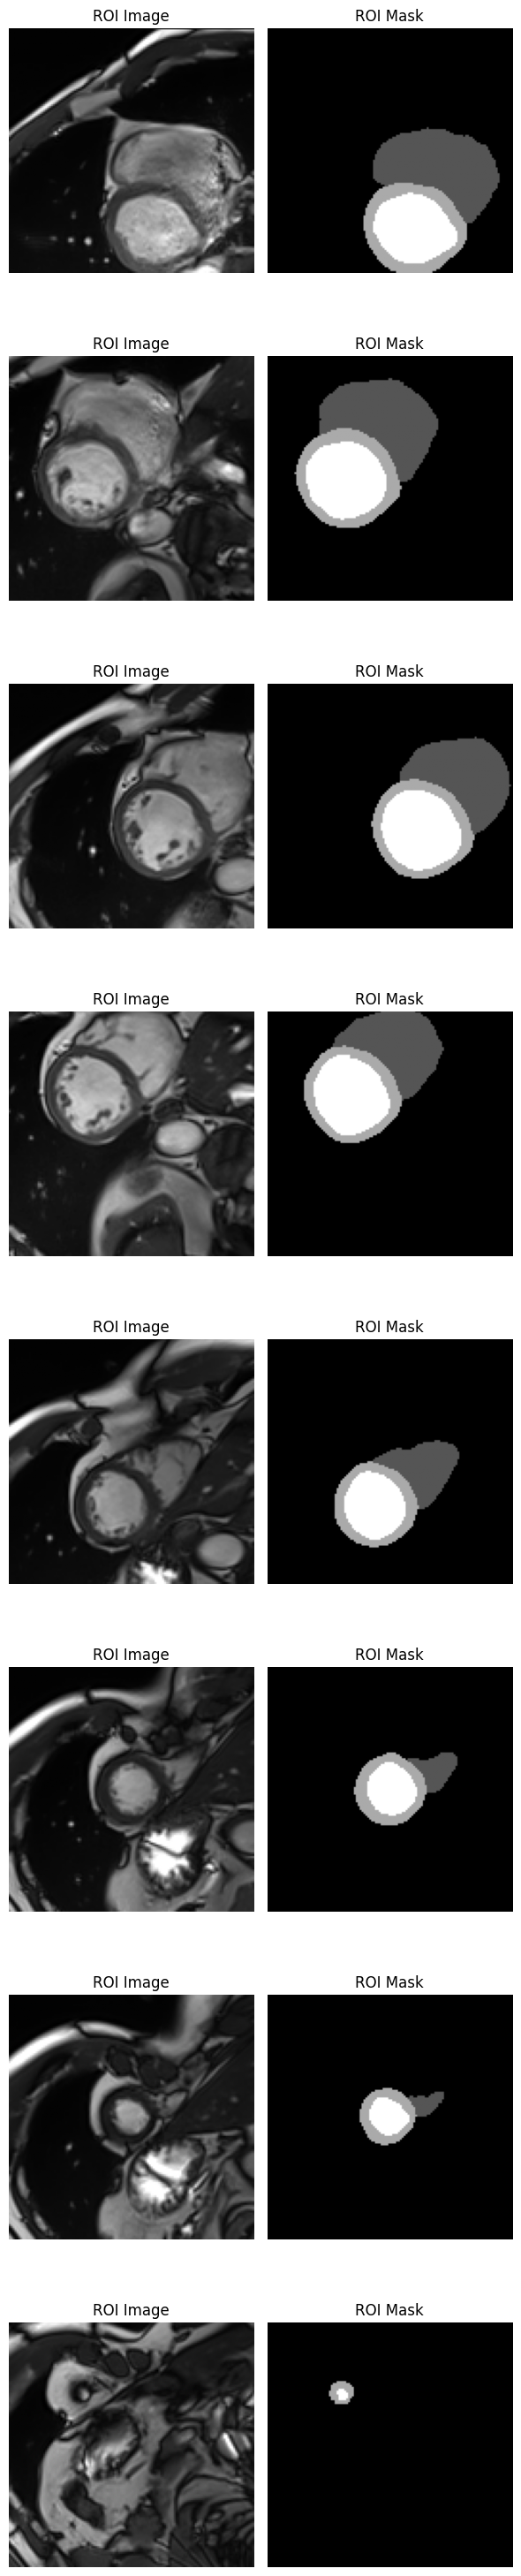

In [2]:
# plot the ROI images
# Load the dataset
roi_extractor = ROI('data/Train')
random.seed(42)
random_int = random.randint(0,100)
roi_image, roi_mask = roi_extractor.get_roi(random_int)

# Create a figure for everty slize in the image
fig, axs = plt.subplots(roi_image.shape[0], 2, figsize=(6, 30))
# Display the image and mask
for index in range(roi_image.shape[0]):
    axs[index, 0].imshow(roi_image[index], cmap='gray')
    axs[index, 1].imshow(roi_mask[index], cmap='gray')
    axs[index, 0].set_title('ROI Image')
    axs[index, 1].set_title('ROI Mask')
    axs[index, 0].axis('off')
    axs[index, 1].axis('off')
plt.tight_layout()
plt.show()



The NiftiDataset is the dataset that I made for this project, it loads the .nii images and returns a (4,220,220,num_slices) tensor. The first 4 correspond to the different images that we have from the same heart, the first one correspond to the end of diastolic phase, the second one to its mask (ground truth), the third one to the end of systolic phase and the last one to its mask.
This dataset have the option to augment the data (with the specifications provided in the paper) and output the ROI for each image (can be augmented as well). All of this was done in order to simplify the training of the densenet.

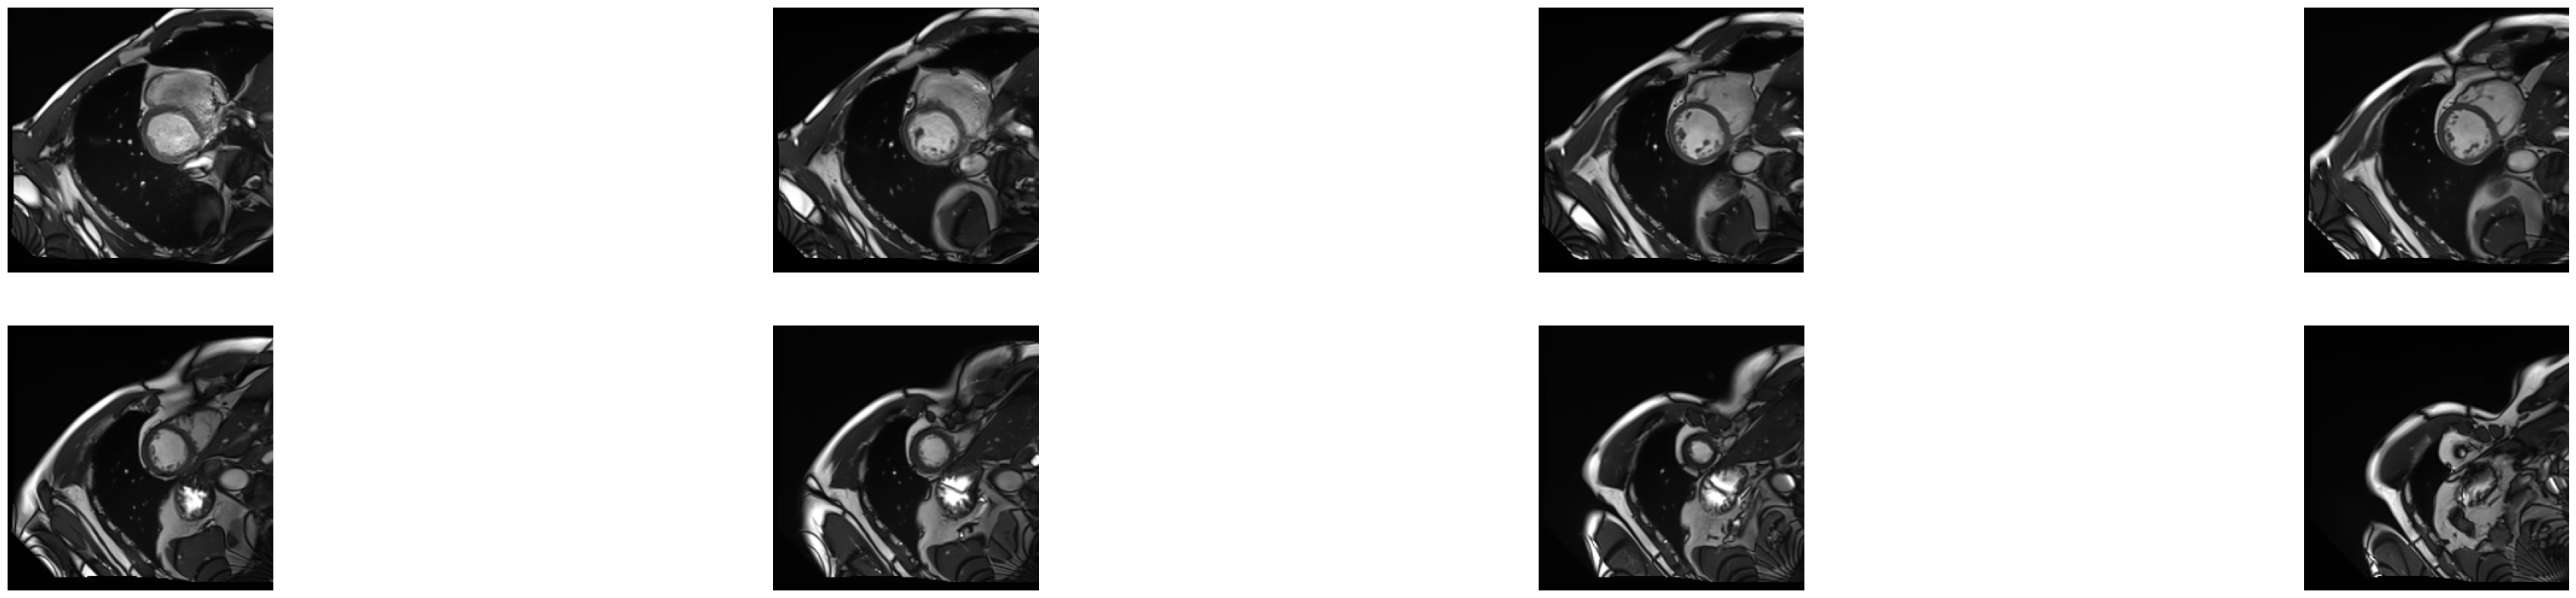

In [3]:
data_path = "./data/Train"
niftiidataset = NiftiDataset(image_path = data_path, roi=False, augment=False)
diastolic_loaded_image = niftiidataset[random_int][0]
# print(diastolic_loaded_image.shape[-1])
amount_of_slices_over_2=int(roi_image.shape[0]/2)
# print(amount_of_slices_over_2)
fig, axs = plt.subplots(2,amount_of_slices_over_2, figsize=(50, 10))
for img_idx in range(diastolic_loaded_image.shape[-1]):
    img = diastolic_loaded_image[:,:,img_idx]
    img_idx_2 = int(img_idx%amount_of_slices_over_2)
    am_img=int(img_idx/amount_of_slices_over_2)
    axs[am_img,img_idx_2].imshow(img, cmap='gray')
    axs[am_img,img_idx_2].imshow(img, cmap='gray')
    axs[am_img,img_idx_2].axis('off')
    axs[am_img,img_idx_2].axis('off')
    # print(img_idx_2, am_img)


After having the image ROI image we will used the densenet described in the paper to segment it, and extract from there the left cavity, right cavity, miocardium and background.
There are two ways of doing this, you can either train the model from the begining or you can use my already trained model, the one that was sent with this work in a .pth file.

In [4]:
# IF set to true will train the model again. The training took me approximately two hours.
Train_model = False
device = torch.device("cuda")

if Train_model:
    model = DenseNet()
    trainer = DenseNetTrainer(data_path)
    # The trainer configuration is like the one in the article
    trainer = DenseNetTrainer(path_to_images, epochs=200, alpha=0.25, train_fraction=0.8, check_val_every=10)
    trainer.train(model=model)
    model.eval()
else:
    # Load the Model
    model = DenseNet()
    # Load the model weights
    model.load_state_dict(torch.load('/home/onyxia/work/project/CardiacPathologyPrediction/model_weights_best_dice_val0.7920951843261719.pth')["model_state_dict"])
    model.to(device)
    model.eval()

In [5]:
torch.load(('/home/onyxia/work/project/CardiacPathologyPrediction/model_weights_best_dice_val0.8000605702400208.pth'))["epoch"]

50

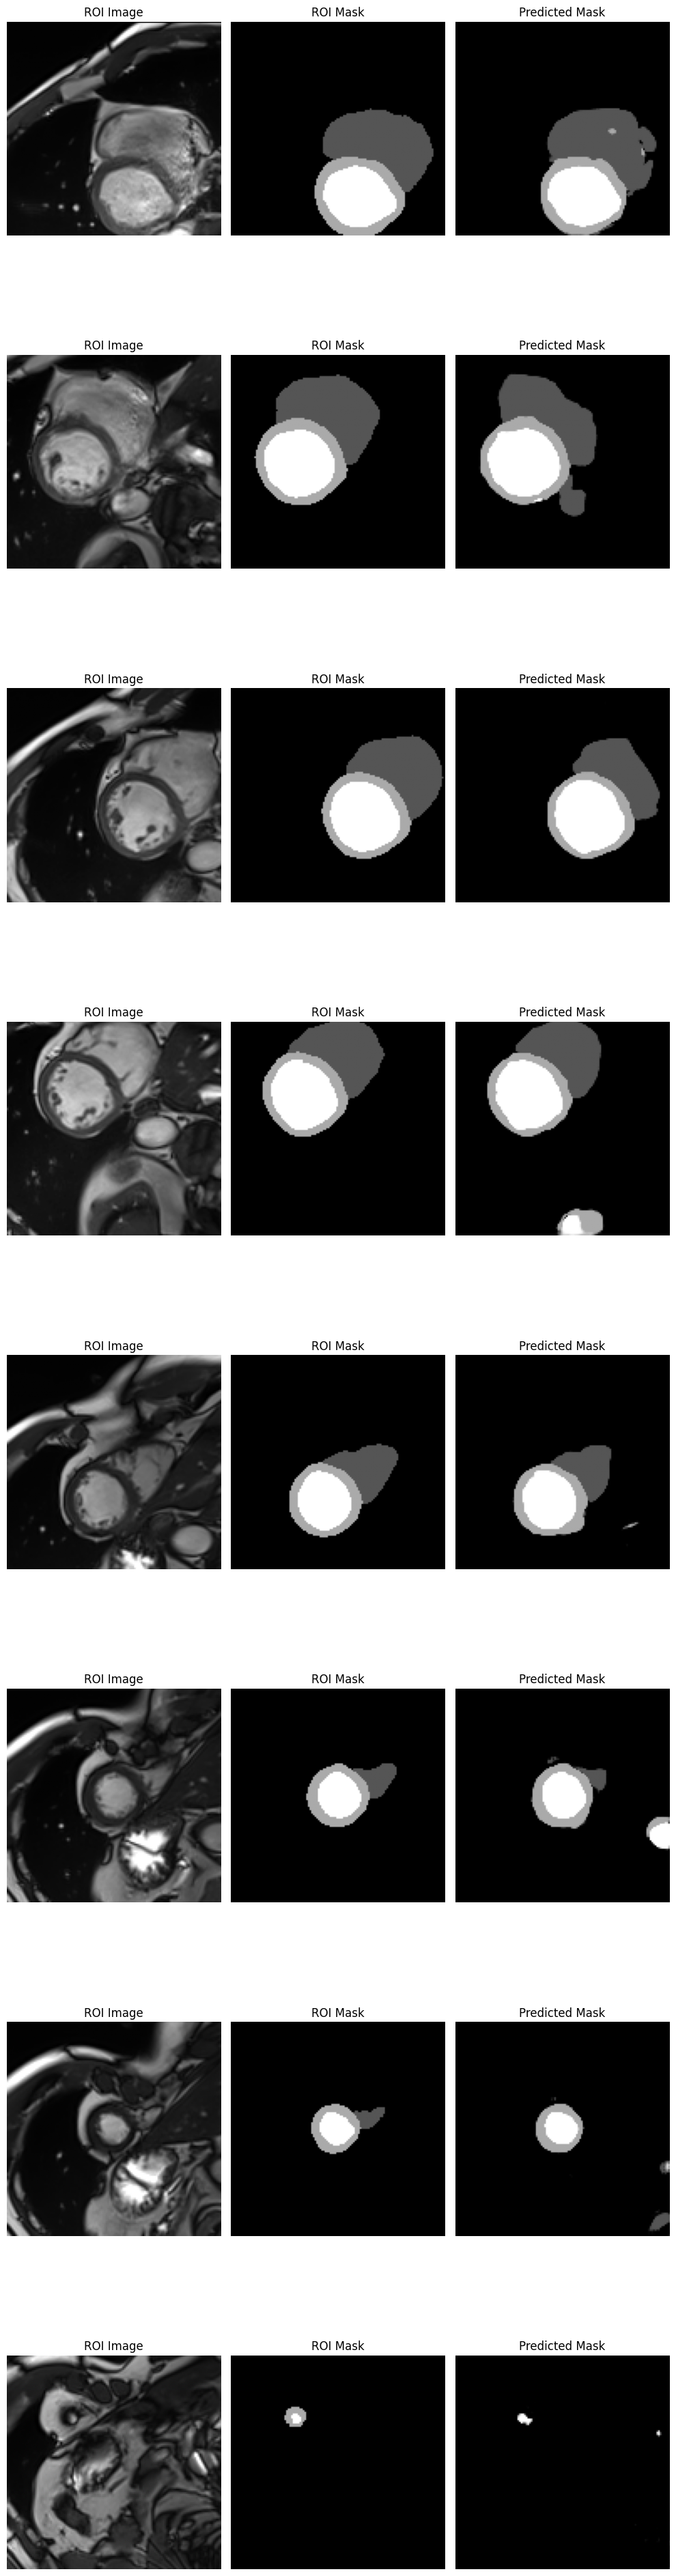

In [6]:
fig, axs = plt.subplots(roi_image.shape[0], 3, figsize=(10, 40))
# Display the image and mask
diastolic_loaded_image_mask = niftiidataset[random_int][1]
for img_idx in range(diastolic_loaded_image.shape[-1]):
    img = diastolic_loaded_image[:,:,img_idx].to(torch.float32)
    mask = diastolic_loaded_image_mask[:,:,img_idx]
    axs[img_idx, 0].imshow(img, cmap='gray')
    axs[img_idx, 1].imshow(mask, cmap='gray')
    img = img.unsqueeze(0).unsqueeze(0)
    # print(img.shape)
    img = img.to(device)
    predicted_mask = model(img).squeeze(0).detach().cpu().numpy()
    pred_mask = 0*predicted_mask[0] + 1*predicted_mask[1] + 2*predicted_mask[2] + 3*predicted_mask[3]
    pred_mask = pred_mask/3
    axs[img_idx, 2].imshow(pred_mask, cmap='gray')
    axs[img_idx, 0].set_title('ROI Image')
    axs[img_idx, 1].set_title('ROI Mask')
    axs[img_idx, 2].set_title('Predicted Mask')
    axs[img_idx, 0].axis('off')
    axs[img_idx, 1].axis('off')
    axs[img_idx, 2].axis('off')
plt.tight_layout()
plt.show()

Now we will use the feature extraction model to extract the features from the 3D the features to use were extracted from the paper: PONER LOS PAPERS DE LAS FEATURES. A random tree is going to be trained after the extraction of the feaures.

In [ ]:
# Masks order: background, right ventricle, myocardium, left ventricle
# Wanted for the feature extraction: (background, left ventricle, right ventricle, myocardium).
#(B, C, H, W)
df = pd.read_csv('/home/onyxia/work/project/CardiacPathologyPrediction/data/metaDataTrain.csv')  # replace with your actual file path
# Show column names (to confirm names like 'Height' and 'Weight')
Heights = df['Height']
Weights = df['Weight']
gt_disease = df['Category']
dataloader = DataLoader(niftiidataset, batch_size=1, shuffle=False, num_workers=1) #This is a batchsize of 1 because the images are 3D
feature_extractor = FeatureExtractor()
features_tensors = []
for idx, img in tqdm(enumerate(dataloader), desc=f"Creating the dataset"):
    # print(img.shape)
    # print(idx)
    
    diastole_image = img[0,0].unsqueeze(0).permute(3, 0, 1, 2).to(torch.float32)
    # print(diastole_image.shape)
    systole_image = img[0,2].unsqueeze(0).permute(3, 0, 1, 2).to(torch.float32)
    # plt.imshow(diastole_image[0,0], cmap='grey')
    # plt.show()
    # plt.imshow(systole_image[0,0], cmap='grey')
    # plt.show()
    diastole_image = diastole_image.to(device)
    predicted_diastole = model(diastole_image).squeeze(0).detach().cpu().numpy()
    systole_image = systole_image.to(device)
    predicted_systole = model(systole_image).squeeze(0).detach().cpu().numpy()
    # predicted_systole = predicted_systole(0.5)
    predicted_systole = (predicted_systole > 0.5).astype(int)
    predicted_diastole = (predicted_diastole > 0.5).astype(int)
    # print(predicted_systole.shape)

    # Reordering the features to match the feature extractor needs
    predicted_systole_tensor = torch.cat((
        torch.from_numpy(predicted_systole[:,0]).unsqueeze(0),
        torch.from_numpy(predicted_systole[:,3]).unsqueeze(0),
        torch.from_numpy(predicted_systole[:,1]).unsqueeze(0),
        torch.from_numpy(predicted_systole[:,2]).unsqueeze(0),
    ), dim=0).permute(1,0,2,3)

    predicted_diastole_tensor = torch.cat((
        torch.from_numpy(predicted_diastole[:,0]).unsqueeze(0),
        torch.from_numpy(predicted_diastole[:,3]).unsqueeze(0),
        torch.from_numpy(predicted_diastole[:,1]).unsqueeze(0),
        torch.from_numpy(predicted_diastole[:,2]).unsqueeze(0),
    ), dim=0).permute(1,0,2,3)

    features_tensor = feature_extractor.extract_features(
        predicted_diastole_tensor, 
        predicted_systole_tensor, 
        Heights[idx], 
        Weights[idx],
    )

    # plt.imshow(predicted_diastole_tensor[0,1], cmap='grey')
    # print("The feature tensor is: ", features_tensor)
    # print("The actual disease is: ", gt_disease[idx])
    features_tensors.append(features_tensor)

    if idx==50:
        break
    

    # plt.imshow(predicted_systole[0,0], cmap='grey')
    # plt.show()
    # plt.imshow(predicted_systole[0,1], cmap='grey')
    # plt.show()
    # plt.imshow(predicted_systole[0,2], cmap='grey')
    # plt.show()
    # plt.imshow(predicted_systole[0,3], cmap='grey')
    # plt.show()
    # break

Creating the dataset: 0it [00:00, ?it/s]

Creating the dataset: 50it [07:07,  8.55s/it]


TRY WITH THE GROUND TRUTH IN THIS CASE TO SE IF IT WORKS.

In [4]:
import torch.nn.functional as F
df = pd.read_csv('/home/onyxia/work/project/CardiacPathologyPrediction/data/metaDataTrain.csv')  # replace with your actual file path
# Show column names (to confirm names like 'Height' and 'Weight')
Heights = df['Height']
Weights = df['Weight']
gt_disease = df['Category']
dataloader = DataLoader(niftiidataset, batch_size=1, shuffle=False, num_workers=16) #This is a batchsize of 1 because the images are 3D
feature_extractor = FeatureExtractor()
features_tensors = []
for idx, img in tqdm(enumerate(dataloader), desc=f"Creating the dataset"):
    predicted_diastole = F.one_hot((img[0,1,:,:,:]*3).long(), num_classes=4).permute(2,3,0,1)
    predicted_systole = F.one_hot((img[0,3,:,:,:]*3).long(), num_classes=4).permute(2,3,0,1)
    # print(predicted_systole.shape)
    # predicted_systole = predicted_systole(0.5)
    # predicted_systole = (predicted_systole > 0.5).astype(int)
    # predicted_diastole = (predicted_diastole > 0.5).astype(int)
    # print(predicted_systole.shape)

    # Reordering the features to match the feature extractor needs
    predicted_systole_tensor = torch.cat((
        (predicted_systole[:,0]).unsqueeze(0),
        (predicted_systole[:,3]).unsqueeze(0),
        (predicted_systole[:,1]).unsqueeze(0),
        (predicted_systole[:,2]).unsqueeze(0),
    ), dim=0).permute(1,0,2,3)

    predicted_diastole_tensor = torch.cat((
        (predicted_diastole[:,0]).unsqueeze(0),
        (predicted_diastole[:,3]).unsqueeze(0),
        (predicted_diastole[:,1]).unsqueeze(0),
        (predicted_diastole[:,2]).unsqueeze(0),
    ), dim=0).permute(1,0,2,3)

    features_tensor = feature_extractor.extract_features(
        predicted_diastole_tensor, 
        predicted_systole_tensor, 
        Heights[idx], 
        Weights[idx],
    )

    # plt.imshow(predicted_diastole_tensor[0,1], cmap='grey')
    # print("The feature tensor is: ", features_tensor)
    # print("The actual disease is: ", gt_disease[idx])
    features_tensors.append(features_tensor)

    # if idx==50:
    #     break
gt_disease = [x for idx, x in enumerate(gt_disease) if features_tensors[idx][0]>1]
features_tensors = [x for x in features_tensors if x[0]>1]


Creating the dataset: 100it [00:04, 21.07it/s]


In [5]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
# features_tensors = np.array(features_tensors)
# gt_disease = [x for idx, x in enumerate(gt_disease) if features_tensors[idx][0]<1]
feat_train, feat_test, label_train, label_test = train_test_split(
    features_tensors, 
    gt_disease, 
    test_size=0.2, 
    random_state=2025
)

# Normalize the data
normalization = MinMaxScaler()
normalization.fit(feat_train)
feat_train = normalization.transform(feat_train)
feat_test = normalization.transform(feat_test)
print(np.unique(label_test))
print(np.unique(label_train))

[0 1 2 3 4]
[0 1 2 3 4]


In [12]:
print(label_train)

[3, 1, 1, 1, 4, 3, 2, 2, 3, 1, 0, 4, 2, 4, 3, 3, 2, 1, 4, 1, 4, 1, 0, 0, 3, 4, 2, 2, 3, 3, 4, 1, 2, 1, 2, 3, 4, 4, 3, 2, 1, 0, 3, 1, 4, 0, 1, 3, 0, 1, 1, 3, 1, 2, 3, 0, 3, 4, 1, 0, 2, 3, 2, 0, 2, 4, 3, 1, 0, 2, 3, 3, 2, 4, 0, 0, 4, 4, 4, 0]


In [10]:
# Get the mean and variance of each class:
mean = np.zeros((5,14))
counter = np.zeros(5)
for ft, cl in zip(features_tensors,gt_disease):
    mean[cl] += ft
    counter[cl] += 1

for i in range(5):
    print(mean[i]/counter[i])

[9.44594495e+02 6.38131441e+02 4.29531340e+01 8.31612268e+02
 5.34543579e+02 4.21182308e+01 5.93805069e+02 6.80371657e+02
 1.29358036e+00 3.50000133e+06 1.30256571e+00 2.70937519e+07
 1.72250000e+02 7.79000000e+01]
[8.22934123e+02 5.40386945e+02 4.05844705e+01 7.42390628e+02
 4.40696852e+02 4.38857789e+01 5.99946281e+02 6.80756299e+02
 1.04956269e+00 1.15645178e+00 8.07827678e-01 2.13722340e+00
 1.72200000e+02 7.41500000e+01]
[816.09754333 407.36988983  53.61661086 867.9444809  492.15498199
  47.17752277 734.40042267 822.29228058   1.26135382   1.71321293
   0.94566094   2.83975573 171.1         75.5       ]
[8.54502005e+02 5.00836118e+02 4.56635961e+01 7.15212778e+02
 3.73807802e+02 4.90120748e+01 6.36215323e+02 7.25674915e+02
 9.31856918e-01 1.07162598e+00 7.59342967e-01 2.04292865e+00
 1.69750000e+02 8.03500000e+01]
[739.67842865 367.0782814   52.88580503 823.87473145 417.73030739
  52.25881157 624.13692627 721.17375031   1.1469125    1.38216337
   0.88904267   2.56587615 168.9     

20
[1.42170000e+04 1.00740000e+04 2.91411705e+01 5.05200000e+03
 1.54200000e+03 6.94774323e+01 8.58300000e+03 1.03020000e+04
 3.55349243e-01 1.53067306e-01 6.03713870e-01 1.02263248e+00
 1.75000000e+02 8.50000000e+01]
[3.27665921e-01 3.07663481e-01 1.97421249e-01 2.15780933e-01
 1.61157246e-01 6.55944344e-01 1.94503280e-01 2.06292050e-01
 1.20504734e-01 1.05260339e-09 3.27568796e-02 1.86099764e-10
 4.90196078e-01 3.97727273e-01]
tensor(10184)


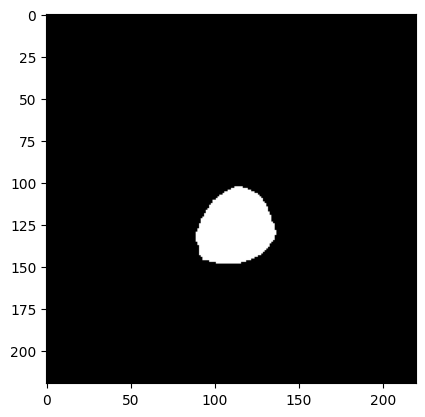

In [49]:
print(len(label_test))
print(features_tensors[23])
print(feat_train[20])
plt.imshow(predicted_diastole_tensor[5,1],cmap='grey')
print(predicted_diastole_tensor[:,3].sum())

In [20]:
for i in features_tensors:
    if i[0]<1:
        print(i)
        print("HOla")

In [65]:
print("Start")

RF=RandomForestClassifier()
p_grid_RF = {'n_estimators':[100, 150, 200],'min_samples_leaf': [2,3,4,5,6], 'max_depth':[None, 2,4,5,6,7,8]}

grid_RF = GridSearchCV(estimator=RF, param_grid=p_grid_RF, scoring="accuracy", cv=10)
grid_RF.fit(feat_train, label_train)

print("Best Validation Score: {}".format(grid_RF.best_score_))
print("Best params: {}".format(grid_RF.best_params_))
print("Random Forest test score :",grid_RF.score(feat_test,label_test))

Start
Best Validation Score: 0.25
Best params: {'max_depth': 4, 'min_samples_leaf': 3, 'n_estimators': 100}
Random Forest test score : 0.1


In [ ]:
import pandas as pd

# Load the CSV
df = pd.read_csv('/home/onyxia/work/project/CardiacPathologyPrediction/data/metaDataTrain.csv')  # replace with your actual file path

# Show column names (to confirm names like 'Height' and 'Weight')
print(df.columns)
Heights = df['Height']
print(Heights[10])
img.shape

Index(['Id', 'Category', 'Height', 'Weight'], dtype='object')
180.0


torch.Size([1, 4, 128, 128, 10])

In [ ]:
RF2=RandomForestClassifier(random_state=200,n_estimators=100, criterion='gini', min_samples_leaf=4, )
RF2.fit(feat_train, label_train)
RF2.score(feat_train, label_train)

0.8625

In [64]:
RF2.score(feat_test, label_test)

0.15

In [28]:
from sklearn.metrics import confusion_matrix
y_pred = RF2.predict(feat_train)
cm = confusion_matrix(label_train, y_pred)
print(cm)

[[ 8  1  0  3  1]
 [ 1 14  2  0  0]
 [ 1  2  9  1  2]
 [ 0  1  1 15  2]
 [ 0  0  2  1 13]]


In [13]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(max_iter=1000)
clf.fit(feat_train, label_train)
print(clf.score(feat_test, label_test))

0.1
